In [ ]:
    import pandas as pd
    import numpy as np
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
    import spacy
    import pytextrank
    import nltk


#### TextBlob is a Python library for Natural Language Processing (NLP).
#### It can do sentiment analysis, part-of-speech tagging, noun phrase extraction, translation, and more.

In [8]:
import pandas as pd

data = pd.read_csv("raw_analyst_ratings.csv", index_col=0)  # index_col=0 ignores Unnamed:0
print(data.head())
print(data.columns)

                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:0

In [9]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB
None
(1407328, 5)


In [24]:
print(type(data['headline']))
print(data['headline'].head())


<class 'pandas.core.series.Series'>
0              Stocks That Hit 52-Week Highs On Friday
1           Stocks That Hit 52-Week Highs On Wednesday
2                        71 Biggest Movers From Friday
3         46 Stocks Moving In Friday's Mid-Day Session
4    B of A Securities Maintains Neutral on Agilent...
Name: headline, dtype: object


In [11]:
# --- 1. Handling Null Values ---

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(data.isnull().sum())

# We focus on the 'headline' column since it's used for sentiment analysis.
# Strategy: Drop rows where the 'headline' is null, as we can't analyze empty text.
data.dropna(subset=['headline'], inplace=True)

print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null headlines: {data.shape[0]}")


--- 1. Null Value Check (Before Cleaning) ---
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64

--- Null Value Check (After Cleaning) ---
Remaining rows after dropping null headlines: 1407328


In [13]:
# --- 3. Duplicate and Consistency Checks ---

# Check for duplicate rows across all columns
duplicate_count = data.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    data.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {data.shape[0]}")

# Ensure the 'headline' column is string type before analysis
data['headline'] = data['headline'].astype(str)


Total duplicate rows found: 1
Rows remaining after dropping duplicates: 1407327


In [ ]:
# --- 2. Date Structure and Time Series Preparation  ---

if 'date' in data.columns:
    
    # 1. Force conversion using 'ISO8601' format and ensure UTC conversion.
    # Setting utc=True handles the mixed timezone offsets by normalizing all values to UTC 
    # and ensures the resulting column is a proper datetime dtype.
    data['date'] = pd.to_datetime(data['date'], format='ISO8601', utc=True)
    
    print("\n--- 2. Date Column Structure (After Conversion) ---")
    print(data['date'].head())
    print(f"Data type is now: {data['date'].dtype}")

    # 2. Set the Index
    # Note: Since utc=True was used, the dates are already in UTC.
    data.set_index('date', inplace=True)
    print("\nDataFrame Index is now set to Date (UTC).")
    print(data.head()) 
    
else:
    print("\nWarning: Date column not found. Skipping date conversion.")


--- 2. Date Column Structure (After Conversion) ---
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]

DataFrame Index is now set to Date (UTC).
                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   

                                                                         url  \
date                                

In [22]:
sample = data.head(100)

In [23]:

sample['TextBlob_Sentiment'] = sample['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)
print(sample[['headline','TextBlob_Sentiment','TextBlob_Category']])


                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   
...                                                                      ...   
2019-10-09 00:00:00+00:00  Barclays Maintains Equal-Weight on Agilent Tec...   
2019-10-08 00:00:00+00:00  Shares of several healthcare companies are tra...   
2019-10-02 00:00:00+00:00  Shares of several healthcare companies are tra...   
2019-09-05 00:00:00+00:00  Shares of several healthcare companies are tra...   
2019-09-03 00:00:00+00:00  Agilent Colla

/tmp/ipykernel_34290/690066906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['TextBlob_Sentiment'] = sample['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
/tmp/ipykernel_34290/690066906.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)


/tmp/ipykernel_34290/3218596432.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


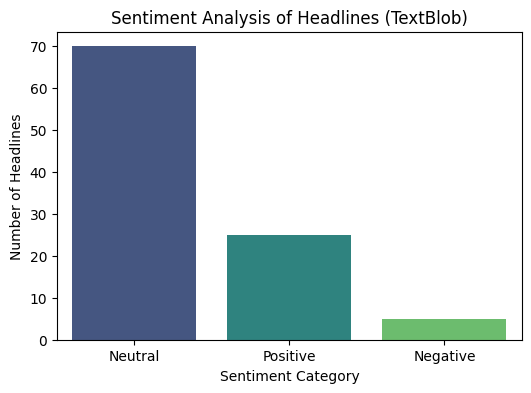

In [24]:
# Count number of headlines in each category
sentiment_counts = sample['TextBlob_Category'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Sentiment Analysis of Headlines (TextBlob)")
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Category")
plt.show()